In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from sklearn.model_selection import KFold

start = time.time()

In [ ]:
dim = (208,176)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2]
layers_unlocked = True        # unlock the imported pre-training layers?                            False
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20                                     50
momentum = .9                 # momentum of SGD                                                     .9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/drive/MyDrive/AlzheimerData/train",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last')
test_data_gen = test_dr.flow_from_directory(directory="/content/drive/MyDrive/AlzheimerData/test/",target_size=dim,batch_size=5000,
                                           shuffle = False)

Found 3351 images belonging to 4 classes.
Found 1086 images belonging to 4 classes.


In [ ]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(4437, 208, 176, 3)
(4437, 4)


In [ ]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (3105, 208, 176, 3)
validation (444, 208, 176, 3)
test (888, 208, 176, 3)


In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(3105, 208, 176, 3)
(3105, 4)
(444, 208, 176, 3)
(444, 4)
(888, 208, 176, 3)
(888, 4)


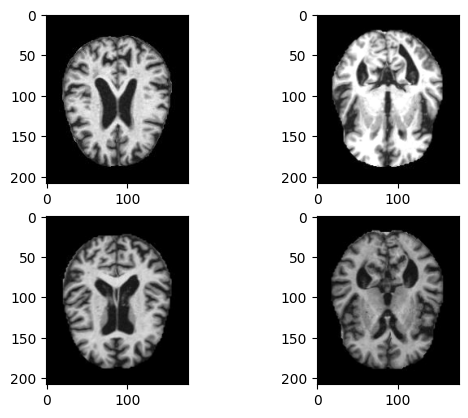

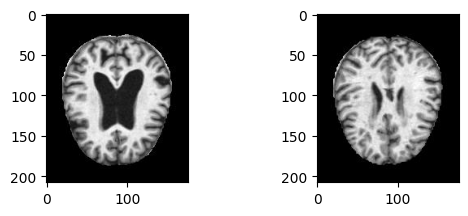

In [ ]:
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
vg_model = VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

# always leave last layer trainable ##
vg_model.get_layer('block5_conv1').trainable = True
vg_model.get_layer('block5_conv2').trainable = True
vg_model.get_layer('block5_conv3').trainable = True

# Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 52, 44, 128)       0     

In [ ]:

opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD')

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=15,batch_size=batch, shuffle=True) #changed batch size from 15

Epoch 1/15
156/156 [==============================] - 59s 255ms/step - loss: 1.1182 - accuracy: 0.4667 - val_loss: 0.9000 - val_accuracy: 0.5833
Epoch 2/15
156/156 [==============================] - 37s 239ms/step - loss: 0.8949 - accuracy: 0.5862 - val_loss: 0.8397 - val_accuracy: 0.6104
Epoch 3/15
156/156 [==============================] - 40s 258ms/step - loss: 0.7785 - accuracy: 0.6525 - val_loss: 0.7650 - val_accuracy: 0.6419
Epoch 4/15
156/156 [==============================] - 41s 266ms/step - loss: 0.6996 - accuracy: 0.6966 - val_loss: 0.7762 - val_accuracy: 0.6644
Epoch 5/15
156/156 [==============================] - 40s 255ms/step - loss: 0.6023 - accuracy: 0.7472 - val_loss: 0.6111 - val_accuracy: 0.7613
Epoch 6/15
156/156 [==============================] - 41s 264ms/step - loss: 0.5206 - accuracy: 0.7852 - val_loss: 0.8313 - val_accuracy: 0.6599
Epoch 7/15
156/156 [==============================] - 40s 257ms/step - loss: 0.4314 - accuracy: 0.8245 - val_loss: 0.4690 - val_ac

In [ ]:
vg_model.save("/content/drive/MyDrive/Alzheimers/208vgg16abcd.h5")

In [ ]:
m = load_model("/content/drive/MyDrive/Alzheimers/208vgg16.h5")
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 52, 44, 128)       0     

In [ ]:
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

28/28 [==============================] - 397s 14s/step - loss: 0.0626 - accuracy: 0.9775
Train Accuracy: 98.97%
Validation Accuracy: 98.42%
Test Accuracy: 97.75%


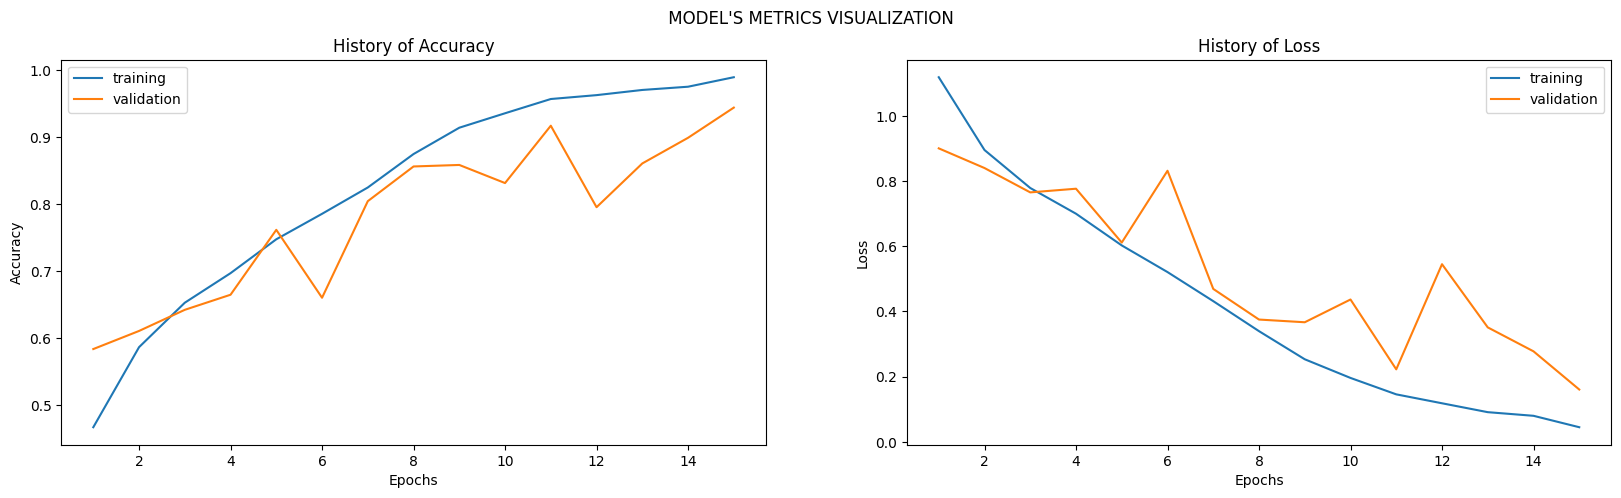

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss']
              )

In [ ]:
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [ ]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
img = load_img("/content/drive/MyDrive/Alzheimers/train/VeryMildDemented/verymildDem1785.jpg")
x = image.img_to_array(img)
print(type(x))
x = np.expand_dims(x, axis=0)
print(np.shape(x))
x = preprocess_input(x)

labels=["a","b","c","d"]

res=m.predict(x)

l = labels[np.argmax(res[0], axis=0)]
l

<class 'numpy.ndarray'>
(1, 208, 176, 3)
1/1 [==============================] - 0s 28ms/step


'c'

In [ ]:

p = decode_predictions(m.predict(x))
p

In [ ]:
t = m.evaluate(test_data, test_labels)
t

In [ ]:
t

VGG19

In [ ]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/drive/MyDrive/Alzheimers/train',
                                                 shuffle=True,
                                                 target_size=(176,208),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/drive/MyDrive/Alzheimers/train',
                                                 shuffle=True,
                                                 target_size=(176,208),
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255)
submission = image_generator_submission.flow_from_directory(
                                                 directory='/content/drive/MyDrive/Alzheimers/test',
                                                 shuffle=False,
                                                 target_size=(176,208),
                                                 class_mode=None)

In [ ]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

In [ ]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

In [ ]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

In [ ]:
history = modelvgg.fit(train_dataset, epochs=20, validation_data=validation_dataset)


In [ ]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['auc'],history.history['val_auc'],
               history.history['loss'],history.history['val_loss']
              )

SVM

In [ ]:
!pip install -U scikit-image
import numpy as np
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
from random import randint
from imblearn.over_sampling import SMOTE
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics,svm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typing import Optional
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
import cv2

In [ ]:
train_images = []
train_target = []
test_images = []
test_target = []

path = '/content/drive/MyDrive/Alzheimers/'

for images in os.listdir(path+'/train/MildDemented'):
    train_images.append(cv2.imread(path+'/train/MildDemented/'+images,cv2.IMREAD_GRAYSCALE)/255)
    train_target.append(0)

for images in os.listdir(path+'/train/ModerateDemented'):
    train_images.append(cv2.imread(path+'/train/ModerateDemented/'+images,cv2.IMREAD_GRAYSCALE)/255)
    train_target.append(1)

for images in os.listdir(path+'/train/NonDemented'):
    train_images.append(cv2.imread(path + '/train/NonDemented/'+images,cv2.IMREAD_GRAYSCALE)/255)
    train_target.append(2)

for images in os.listdir(path + '/train/VeryMildDemented'):
    train_images.append(cv2.imread(path + '/train/VeryMildDemented/'+images,cv2.IMREAD_GRAYSCALE)/255)
    train_target.append(3)

for images in os.listdir(path + '/test/MildDemented'):
    test_images.append(cv2.imread(path + '/test/MildDemented/'+images,cv2.IMREAD_GRAYSCALE)/255)
    test_target.append(0)

for images in os.listdir(path + '/test/ModerateDemented'):
    test_images.append(cv2.imread(path + '/test/ModerateDemented/'+images,cv2.IMREAD_GRAYSCALE)/255)
    test_target.append(3)

train_images = np.array(train_images)
train_target = np.array(train_target)
test_images = np.array(test_images)
test_target = np.array(test_target)

In [ ]:
train_images=train_images.reshape(len(train_images),-1)
test_images=test_images.reshape(len(test_images),-1)
print(train_images.shape)
print(train_target.shape)
print(test_images.shape)
print(test_target.shape)

In [ ]:
classifier = svm.SVC(gamma=0.001)
classifier.fit(train_images,train_target)

In [ ]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
pred_target = classifier.predict(test_images)
from sklearn.metrics import classification_report, confusion_matrix
conf_arr = confusion_matrix(test_target,pred_target)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(test_target,pred_target))

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_target,pred_target)*100)

DenseNet(ANN)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D

!pip install tensorflow-addons

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimers/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimers/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimers/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)


In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=4))
model.add(Activation('softmax'))
model.summary()

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',), loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1)

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
scores = model.evaluate(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

CNN